## Analysis of google reviews

In [1]:
import pandas as pd

### import data and drop columns 

In [117]:
df = pd.read_csv("../raw_data/reviews.csv", header=None)

df.columns = ["Index", "Restaurant", "Reviewer", "Score", "When", "Review"]

df.drop(columns=["Index", "Reviewer", "When"], inplace=True)

In [147]:
df.head()

,Restaurant,Score,Review
0,Darshan Nepal,"Classificação: 4,5 de 5,","(Traduzido pelo Google) Muito boa comida, boa ..."
1,Darshan Nepal,"Classificação: 4,0 de 5,",(Traduzido pelo Google) Voe para Lisboa se sen...
2,Darshan Nepal,"Classificação: 3,5 de 5,",(Traduzido pelo Google) Comida deliciosa e uma...
3,Darshan Nepal,"Classificação: 3,0 de 5,","(Traduzido pelo Google) Muito boa comida, boa ..."
4,Darshan Nepal,"Classificação: 2,5 de 5,",(Traduzido pelo Google) Voe para Lisboa se sen...


In [156]:
df.shape

(90732, 3)

In [161]:
df.drop_duplicates(inplace=True)

In [162]:
df.shape

(6310, 3)

In [169]:
cleaned_df = df.dropna()

### Score column

In [170]:
cleaned_df.Score.unique()

array(['Classificação: 4,5 de 5,', 'Classificação: 4,0 de 5,',
       'Classificação: 3,5 de 5,', 'Classificação: 3,0 de 5,',
       'Classificação: 2,5 de 5,', 'Classificação: 2,0 de 5,',
       'Classificação: 4,4 de 5,', 'Classificação: 4,1 de 5,',
       'Classificação: 5,0 de 5,', 'Classificação: 4,6 de 5,',
       'Classificação: 4,8 de 5,', 'Classificação: 4,7 de 5,',
       'Classificação: 1,0 de 5,', 'Classificação: 4,3 de 5,',
       'Classificação: 4,2 de 5,'], dtype=object)

In [171]:
def extract_score(series):
    return float(series[15:18].replace(",","."))

In [172]:
cleaned_df['Score'] = cleaned_df['Score'].apply(extract_score)

/tmp/ipykernel_565/3020042498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Score'] = cleaned_df['Score'].apply(extract_score)


In [173]:
cleaned_df.head()

,Restaurant,Score,Review
0,Darshan Nepal,4.5,"(Traduzido pelo Google) Muito boa comida, boa ..."
1,Darshan Nepal,4.0,(Traduzido pelo Google) Voe para Lisboa se sen...
2,Darshan Nepal,3.5,(Traduzido pelo Google) Comida deliciosa e uma...
3,Darshan Nepal,3.0,"(Traduzido pelo Google) Muito boa comida, boa ..."
4,Darshan Nepal,2.5,(Traduzido pelo Google) Voe para Lisboa se sen...


array([[<AxesSubplot:title={'center':'Score'}>]], dtype=object)

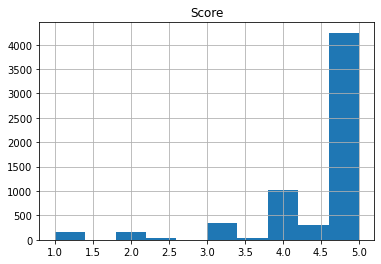

In [174]:
cleaned_df.hist()

### Clean Reviews

In [175]:
def remove_google_trans_comment(series):
    if "(Traduzido pelo Google)" in series:
        return series.replace("(Traduzido pelo Google) ","")
    else:
        return series    

In [176]:
cleaned_df.Review = cleaned_df.Review.apply(remove_google_trans_comment)

/home/jamie/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [180]:
cleaned_df.reset_index(drop=True)

,Restaurant,Score,Review
0,Darshan Nepal,4.5,"Muito boa comida, boa garçonete de senhora. Pe..."
1,Darshan Nepal,4.0,Voe para Lisboa se sentir falta da autêntica c...
2,Darshan Nepal,3.5,Comida deliciosa e uma equipe muito simpática ...
3,Darshan Nepal,3.0,"Muito boa comida, boa garçonete de senhora. Pe..."
4,Darshan Nepal,2.5,Voe para Lisboa se sentir falta da autêntica c...
...,...,...,...
6277,Spice Hut Tandoori,5.0,Discreto e caro\n\n(Original)\nDiscreto e caro
6278,Spice Hut Tandoori,4.0,O melhor em qualidade e boas-vindas\n\n(Origin...
6279,Spice Hut Tandoori,4.0,Tratamento impecável e comida imbatível\n\n(Or...
6280,Spice Hut Tandoori,5.0,Super bom chefe\n\n(Original)\nPatron super sympa
